In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import gillespy2

In [3]:
import time
import numpy
import scipy.stats
from matplotlib import pyplot as plt
import pickle
import copy

In [4]:
sys.path.append('../test/')
import example_models

In [5]:
all_model_names = [
 'create_decay',
 'create_dimerization',
 'create_michaelis_menten',
 'create_toggle_switch',
]

# Tau Stepsize Convergence

In [6]:
def run_model_tau_convergence(model, cache):
    #0==auto step size selection
    tau_stepsize_values = [0, 1, 7.5e-1, 5e-1, 3.5e-1, 2e-1, 1e-1, 5e-2, 2.5e-2, 1e-2]  

    Ntraj=1e3
    tau_solvers = [gillespy2.TauHybridSolver, 
                   gillespy2.TauHybridCSolver,
                   gillespy2.TauLeapingSolver,
                   gillespy2.TauLeapingCSolver,
                  ]
    ssa_solvers = [gillespy2.NumPySSASolver, gillespy2.SSACSolver]
    
    # run SSA solvers to show noise floor
    if 0 not in cache:
        cache[0] = {}
    for solver in ssa_solvers:
        if solver.name not in cache[0]:
            cache[0][solver.name] = {}
        for batch in ['A', 'B']:
            if batch in cache[0][solver.name]: 
                print(f"cached  Ntraj={int(Ntraj)} {solver.name} {batch}")
            else:
                ##
                print(f"running Ntraj={int(Ntraj)} {solver.name} {batch}", end='')
                tic = time.time()
                result = model.run(solver=solver, number_of_trajectories=int(Ntraj))
                print(f"\t\tdone in {time.time()-tic}")
                ##
                a = 0
                b = len(result[0]['time'])
                dist = numpy.zeros((b-a,len(model.listOfSpecies),int(Ntraj)))
                #
                for s_ndx,species in enumerate(model.listOfSpecies):
                    for n_ndx in range(int(Ntraj)):
                        dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
                #
                cache[0][solver.name][batch] = dist

    
    
    ignore_cache_list = [
        #'TauHybridCSolver',
        #'TauHybridSolver',
    ]
    
    # run all the Tau solvers
    for tau_stepsize in tau_stepsize_values:
        tau_stepsize_s=tau_stepsize
        if tau_stepsize==0: tau_stepsize_s='<auto>'
        if tau_stepsize not in cache:
            cache[tau_stepsize] = {}
        for solver in tau_solvers:
            if solver.name in cache[tau_stepsize]:
                if solver.name in ignore_cache_list and tau_stepsize==0:
                    print(f"cached-rerunning  tau={tau_stepsize_s} {solver.name}")
                else:
                    print(f"cached  tau={tau_stepsize_s} {solver.name}")
                    continue
            ##
            print(f"running tau={tau_stepsize_s} {solver.name}", end='')
            mymodel = copy.deepcopy(model)
            print("\n\t converting all species to 'discrete'")
            for species in mymodel.listOfSpecies:
                mymodel.listOfSpecies[species].mode='discrete'

            tic = time.time()
            if tau_stepsize==0:
                sol_obj = solver(model=mymodel)
            else:
                sol_obj = solver(model=mymodel, constant_tau_stepsize=tau_stepsize)
            result = sol_obj.run(number_of_trajectories=int(Ntraj))
            print(f"\t\tdone in {time.time()-tic}")
            ##
            a = 0
            b = len(result[0]['time'])
            dist = numpy.zeros((b-a,len(mymodel.listOfSpecies),int(Ntraj)))
            #
            for s_ndx,species in enumerate(mymodel.listOfSpecies):
                for n_ndx in range(int(Ntraj)):
                    dist[:,s_ndx,n_ndx] = result[n_ndx][species][a:]
            #
            cache[tau_stepsize][solver.name] = dist
                
    
    ############################################################
    def __analyze_full(data1,data2):
        out_arr = numpy.zeros((len(model.listOfSpecies),data1.shape[0]))
        for s_ndx,species in enumerate(model.listOfSpecies):
            for t_ndx in range(data1.shape[0]):
                out_arr[s_ndx,t_ndx] = scipy.stats.ks_2samp(
                            data1[t_ndx,s_ndx,:], 
                            data2[t_ndx,s_ndx,:]
                                    ).statistic
        return out_arr
    def __analyze_one(data1,data2):
        d_sum = 0
        d_ssum = 0
        d_cnt = 0
        for s_ndx,species in enumerate(model.listOfSpecies):
            for t_ndx in range(data1.shape[0]):
                d_cnt += 1
                val = scipy.stats.ks_2samp(
                            data1[t_ndx,s_ndx,:], 
                            data2[t_ndx,s_ndx,:]
                                    ).statistic
                d_sum += val
                d_ssum += val*val
        mu = d_sum/d_cnt
        sigma = d_ssum/d_cnt - (mu*mu)
        return (mu, sigma)
    
    def __analyze_all_tau(solver_name):
        x_vals = sorted(tau_stepsize_values)
        y_vals = numpy.zeros(len(x_vals))
        y_errs = numpy.zeros(len(x_vals))
        for y_ndx,tau_stepsize in enumerate(x_vals):
            (y_vals[y_ndx],y_errs[y_ndx]) = __analyze_one(
                        cache[0]['NumPySSASolver']['A'],
                        cache[tau_stepsize][solver_name]
                    )
        err_full = __analyze_full(
                    cache[0]['NumPySSASolver']['A'],
                    cache[0][solver_name]
                )
        return (x_vals, y_vals, y_errs, err_full)
    ############################################################
    # Analyze results
    tau_convergence_results_analysis={}

    print("Analyzing: NumPySSASolver-self")
    tau_convergence_results_analysis['NumPySSASolver-self'] = __analyze_one(
            cache[0]['NumPySSASolver']['A'],
            cache[0]['NumPySSASolver']['B']
        )
    
    print("Analyzing: SSACSolver-self")
    tau_convergence_results_analysis['SSACSolver-self'] = __analyze_one(
            cache[0]['SSACSolver']['A'],
            cache[0]['SSACSolver']['B']
        )
    
    print("Analyzing: NumPySSASolver-SSACSolver")
    tau_convergence_results_analysis['NumPySSASolver-SSACSolver'] = __analyze_one(
            cache[0]['NumPySSASolver']['A'],
            cache[0]['SSACSolver']['A']
        )
    
    
    print("Analyzing: TauHybridSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauHybridSolver-NumPySSASolver'] = __analyze_all_tau('TauHybridSolver')
    
    print("Analyzing: TauHybridCSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauHybridCSolver-NumPySSASolver'] = __analyze_all_tau('TauHybridCSolver')

    print("Analyzing: TauLeapingSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauLeapingSolver-NumPySSASolver'] = __analyze_all_tau('TauLeapingSolver')

    print("Analyzing: TauLeapingCSolver-NumPySSASolver")
    tau_convergence_results_analysis['TauLeapingCSolver-NumPySSASolver'] = __analyze_all_tau('TauLeapingCSolver')

    return tau_convergence_results_analysis

In [7]:
def plot_model_tau_convergence(model, tau_convergence_results_analysis):
    plt.figure()
    for name in tau_convergence_results_analysis:
        if name[0:3] == 'Tau':
            (x_vals, y_vals, y_errs, err_full) = tau_convergence_results_analysis[name]
            plt.errorbar(x_vals[1:],y_vals[1:],yerr=y_errs[1:],fmt='.-',capsize=8,label=name.split('-')[0])
            plt.plot([0,max(x_vals)],[y_vals[0],y_vals[0]],'.:',label=f"{name.split('-')[0]} [AUTO]")
    for name in tau_convergence_results_analysis:
        if name[0:3] != 'Tau':
            ssa_self = tau_convergence_results_analysis[name][0]
            plt.plot([0,max(x_vals)],[ssa_self, ssa_self], label=name)
    plt.ylabel("KS-distance")
    plt.xlabel("tau step size")
    plt.title(model.name)
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
def plot_model_errorbars(model, cache):
    plt.figure()
    species= list(model.listOfSpecies.keys())
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname}")
        for solver in cache[0]:
            if solver[0:3] == 'Tau':
                y_vals = numpy.mean(cache[0][solver][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                y_errs = numpy.var(cache[0][solver][:,s_ndx,:], axis=1)
                plt.errorbar(x_vals,y_vals,yerr=y_errs,fmt='.-',capsize=8,
                              label=solver)
            else:
                y_vals = numpy.mean(cache[0][solver]['A'][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                y_errs = numpy.var(cache[0][solver]['A'][:,s_ndx,:], axis=1)
                plt.errorbar(x_vals,y_vals,yerr=y_errs,fmt='.-',capsize=8,
                              label=solver)
        plt.ylabel("Population")
        plt.xlabel("time")
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [9]:
def plot_model_means(model, cache):
    species= list(model.listOfSpecies.keys())
    plt.figure(figsize=(12,6*len(species)))
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname}")
        for solver in cache[0]:
            if solver[0:3] == 'Tau':
                y_vals = numpy.mean(cache[0][solver][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                plt.plot(x_vals,y_vals,label=solver)
            else:
                y_vals = numpy.mean(cache[0][solver]['A'][:,s_ndx,:], axis=1)
                x_vals = numpy.arange(len(y_vals))
                plt.plot(x_vals,y_vals,label=solver)
        plt.ylabel("Population")
        plt.xlabel("time")
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [10]:
def plot_model_trajectories(model, cache):
    sol_colors = ['cyan','blue','red','green','magenta','black']
    species= list(model.listOfSpecies.keys())
    plt.figure(figsize=(12,6*len(species)))
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname}")
        for sol_ndx, solver in enumerate(cache[0]):
            #if solver == 'NumPySSASolver': continue
            if solver == 'SSACSolver': continue
            #if solver == 'TauHybridSolver': continue
            if solver == 'TauHybridCSolver': continue
            if solver == 'TauLeapingSolver': continue
            if solver == 'TauLeapingCSolver': continue

            if solver[0:3] == 'Tau':
                #x_vals = numpy.arange(cache[0][solver].shape[0])
                x_vals = numpy.arange(10)
                for n_ndx in range(cache[0][solver].shape[2]):
                    y_vals = cache[0][solver][0:10,s_ndx,n_ndx]
                    if n_ndx==0:
                        plt.plot(x_vals,y_vals,color=sol_colors[sol_ndx],
                                 label=solver)
                    else:
                        plt.plot(x_vals,y_vals,alpha=0.01,color=sol_colors[sol_ndx])
            else:
                #x_vals = numpy.arange(cache[0][solver]['A'].shape[0])
                x_vals = numpy.arange(10)
                for n_ndx in range(cache[0][solver]['A'].shape[2]):
                    y_vals = cache[0][solver]['A'][0:10,s_ndx,n_ndx]
                    if n_ndx==0:
                        plt.plot(x_vals,y_vals,label=solver)
                    else:
                        plt.plot(x_vals,y_vals,alpha=0.01)
        plt.ylabel("Population")
        plt.xlabel("time")
    _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [11]:
def plot_model_trajectory_hist(model, cache):
    sol_colors = ['cyan','blue','red','green','magenta','black']
    species= list(model.listOfSpecies.keys())
    sol_blocks = [
        ['NumPySSASolver','TauHybridSolver','TauLeapingSolver'],
        ['SSACSolver','TauHybridCSolver','TauLeapingCSolver'],
    ]
    for sol_list in sol_blocks:
        plt.figure(figsize=(12,6*len(species)))
        n=1
        for t_ndx in range(10):
            for s_ndx, sname in enumerate(species):
                plt.subplot(10,len(species),n)
                n+=1
                plt.title(f"{sname} t={t_ndx}")
                h_colors = []
                h_data = []
                h_labels = []
                for sol_ndx, solver in enumerate(sol_list):

                    if solver[0:3] == 'Tau':
                        #plt.hist(cache[0][solver][t_ndx,s_ndx,:],
                        #        color=sol_colors[s_ndx], label=solver)
                        h_data.append(cache[0][solver][t_ndx,s_ndx,:])
                        h_colors.append(sol_colors[sol_ndx])
                        h_labels.append(solver)
                    else:
                        #plt.hist(cache[0][solver]['A'][t_ndx,s_ndx,:],
                        #        color=sol_colors[s_ndx], label=solver)
                        h_data.append(cache[0][solver]['A'][t_ndx,s_ndx,:])
                        h_colors.append(sol_colors[sol_ndx])
                        h_labels.append(solver)
                plt.hist(h_data, color=h_colors, label=h_labels)
                #plt.ylabel("Population")
                #plt.xlabel("time")
                if t_ndx==0 and s_ndx==0:
                    _=plt.legend(loc='center left')
        #_=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [12]:
def plot_model_image_maps(model, tau_convergence_results_analysis):
    sol_colors = ['cyan','blue','red','green','magenta','grey']
    species= list(model.listOfSpecies.keys())
    plt.figure(figsize=(12,6*len(species)))
    for s_ndx, sname in enumerate(species):
        plt.subplot(len(species),1,s_ndx+1)
        plt.title(f"species={sname} (discrete)")

        for name in tau_convergence_results_analysis:
            if name[0:3] == 'Tau':
                (x_vals, y_vals, y_errs, err_full) = tau_convergence_results_analysis[name]
                plt.plot(range(10),err_full[s_ndx,0:10],label=f"{name.split('-')[0]} [AUTO]")

        plt.ylabel("KS-distance")
        plt.xlabel("time")
        _=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# run all models tau convergence

In [13]:
all_models_tau_convergence_cache = {}
try:
    with open('all_models_tau_convergence_cache.p','rb') as fd:
        all_models_tau_convergence_cache = pickle.load(fd)
except FileNotFoundError: pass
print(sorted(list(all_models_tau_convergence_cache.keys())))

['create_decay', 'create_dimerization', 'create_michaelis_menten', 'create_opioid', 'create_schlogl', 'create_toggle_switch', 'create_tyson_2_state_oscillator', 'create_vilar_oscillator']


In [14]:
all_model_names

['create_decay',
 'create_dimerization',
 'create_michaelis_menten',
 'create_toggle_switch']

Decay
cached  Ntraj=1000 NumPySSASolver A
cached  Ntraj=1000 NumPySSASolver B
cached  Ntraj=1000 SSACSolver A
cached  Ntraj=1000 SSACSolver B
cached  tau=<auto> TauHybridSolver
cached  tau=<auto> TauHybridCSolver
cached  tau=<auto> TauLeapingSolver
cached  tau=<auto> TauLeapingCSolver
cached  tau=1 TauHybridSolver
cached  tau=1 TauHybridCSolver
cached  tau=1 TauLeapingSolver
cached  tau=1 TauLeapingCSolver
cached  tau=0.75 TauHybridSolver
cached  tau=0.75 TauHybridCSolver
cached  tau=0.75 TauLeapingSolver
cached  tau=0.75 TauLeapingCSolver
cached  tau=0.5 TauHybridSolver
cached  tau=0.5 TauHybridCSolver
cached  tau=0.5 TauLeapingSolver
cached  tau=0.5 TauLeapingCSolver
cached  tau=0.35 TauHybridSolver
cached  tau=0.35 TauHybridCSolver
cached  tau=0.35 TauLeapingSolver
cached  tau=0.35 TauLeapingCSolver
cached  tau=0.2 TauHybridSolver
cached  tau=0.2 TauHybridCSolver
cached  tau=0.2 TauLeapingSolver
cached  tau=0.2 TauLeapingCSolver
cached  tau=0.1 TauHybridSolver
cached  tau=0.1 TauHyb

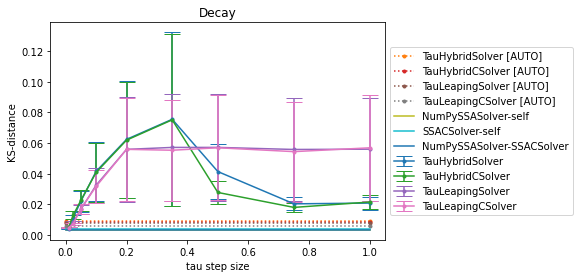

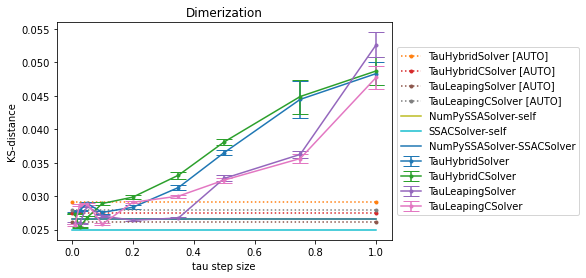

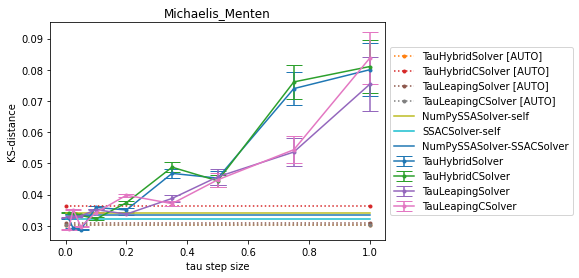

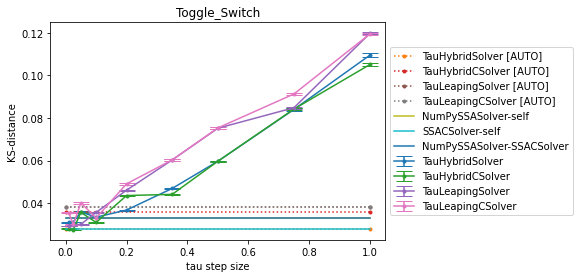

In [15]:
for m_ndx, mname in enumerate(all_model_names):
    mobj = eval(f"example_models.{mname}")()
    print(mobj.name)
    tic = time.time()
    if mname not in all_models_tau_convergence_cache:
        all_models_tau_convergence_cache[mname] = {}
    analysis_results = run_model_tau_convergence(mobj, all_models_tau_convergence_cache[mname])
    #plot_model_errorbars(mobj, all_models_tau_convergence_cache[mname])
    #plot_model_trajectories(mobj, all_models_tau_convergence_cache[mname])
    #plot_model_trajectory_hist(mobj, all_models_tau_convergence_cache[mname])
    plot_model_tau_convergence(mobj, analysis_results)
    #plot_model_image_maps(mobj, analysis_results)
    #plot_model_means(mobj, all_models_tau_convergence_cache[mname])
    print(f"\t\tdone in {time.time()-tic}")


In [16]:
with open('all_models_tau_convergence_cache.p','wb+') as fd:
    pickle.dump(all_models_tau_convergence_cache,fd)